<a href="https://colab.research.google.com/github/osgeokr/GEE-PAM-Book/blob/main/Chapter6_Species_Distribution_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6장. 종 분포 모델링: GEE를 활용한 서식지 예측 및 분석

## 6.2. GEE를 활용한 서식지 예측 및 분석

###  6.2.1. 종 출현 데이터 수집 및 처리

In [ ]:
# 라이브러리 설치
%pip install -U -q pyarrow
%pip install -U -q geopandas
%pip install -U -q pycrs
%pip install -U -q statsmodels

In [1]:
# 라이브러리 호출
import ee
import geemap

import geemap.colormaps as cm
import pandas as pd, geopandas as gpd
import numpy as np, matplotlib.pyplot as plt
import os, requests, math, random

from ipyleaflet import TileLayer
from statsmodels.stats.outliers_influence \
    import variance_inflation_factor

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-foss4g')

In [3]:
# GBIF API 파라미터 설정
species_name = "Pitta nympha" # 학명
country_code = "KR" # 국가코드
base_url = "https://api.gbif.org/v1/occurrence/search"
params = {
    "scientificName": species_name, # 학명
    "country": country_code, # 국가
    "hasCoordinate": "true", # 좌표 유무
    "basisOfRecord": "HUMAN_OBSERVATION", # 인간에 의한 관측
    "limit": 10000, # 최대 10,000개 결과 반환
}

In [4]:
# GBIF API 호출
response = requests.get(base_url, params=params)
data = response.json() # dict
occurrences = data["results"] # list

# List를 DataFrame으로 변환
df = pd.json_normalize(occurrences)
df.head(1)

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,nomenclaturalCode,fieldNotes,verbatimElevation,behavior,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,distanceFromCentroidInMeters,associatedTaxa,lifeStage,occurrenceRemarks
0,4126765284,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2024-01-23T16:28:21.693+00:00,2024-01-24T01:53:07.102+00:00,431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# DataFrame을 CSV로 저장
df.to_csv("pitta_nympha_data.csv", index=False)
df = pd.read_csv("pitta_nympha_data.csv")
df.head(1)

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,nomenclaturalCode,fieldNotes,verbatimElevation,behavior,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,distanceFromCentroidInMeters,associatedTaxa,lifeStage,occurrenceRemarks
0,4126765284,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2024-01-23T16:28:21.693+00:00,2024-01-24T01:53:07.102+00:00,431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# DataFrame을 GeoDataFrame으로 변환
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.decimalLongitude,
                                df.decimalLatitude),
    crs="EPSG:4326"
)[["species", "year", "month", "geometry"]]
gdf.head(1)

,species,year,month,geometry
0,Pitta nympha,2023,5,POINT (126.72514 33.20314)


In [7]:
# GeoDataFrame을 GeoPackage로 변환
gdf.to_file("pitta_nympha_data.gpkg", driver="GPKG")
gdf = gpd.read_file("pitta_nympha_data.gpkg")
gdf.head(1)

,species,year,month,geometry
0,Pitta nympha,2023,5,POINT (126.72514 33.20314)


In [8]:
# 연도(year)와 월별(month) 데이터 분포 시각화
def plot_data_distribution(gdf, h_size=12):

    plt.figure(figsize=(h_size, h_size-8))

    # 연도별 데이터 분포 그래프 (왼쪽)
    plt.subplot(1, 2, 1)
    year_counts = gdf['year'].value_counts().sort_index()
    plt.bar(year_counts.index, year_counts.values)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Yearly Data Distribution')

    # 막대 그래프 위에 데이터 개수 표시
    for i, count in enumerate(year_counts.values):
        plt.text(year_counts.index[i], count, str(count), ha='center', va='bottom')

    # 월별 데이터 분포 그래프 (오른쪽)
    plt.subplot(1, 2, 2)
    month_counts = gdf['month'].value_counts().sort_index()
    plt.bar(month_counts.index, month_counts.values)
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.title('Monthly Data Distribution')

    # 막대 그래프 위에 데이터 개수 표시
    for i, count in enumerate(month_counts.values):
        plt.text(month_counts.index[i], count, str(count), ha='center', va='bottom')

    # x 축의 눈금을 정수 형식으로 설정
    plt.xticks(month_counts.index, map(int, month_counts.index))

    # 그래프 출력
    plt.tight_layout()
    plt.savefig('data_distribution_plot.png')
    plt.show()

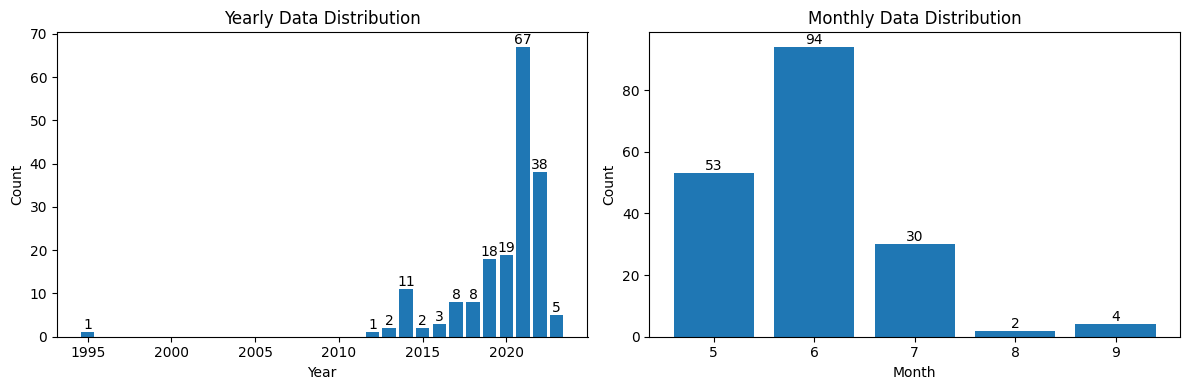

In [9]:
plot_data_distribution(gdf)

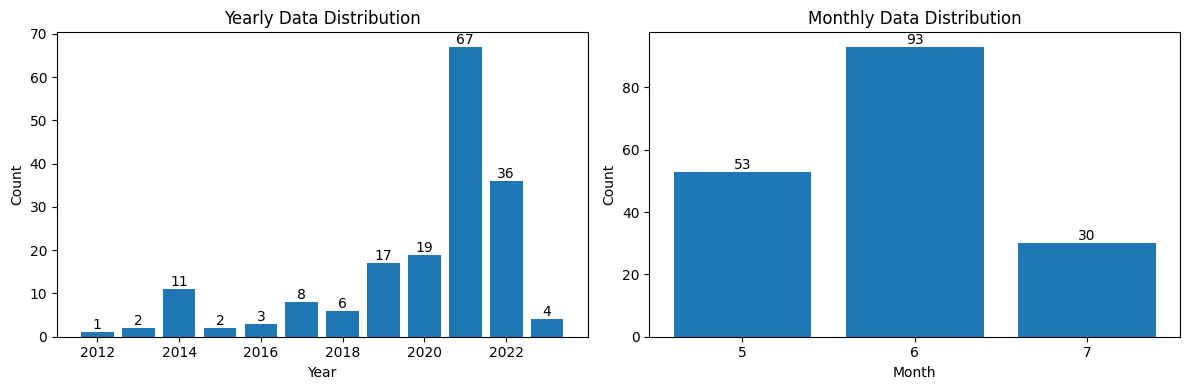

In [10]:
# 연도와 월별 데이터 필터링
filtered_gdf = gdf[
    (~gdf['year'].eq(1995)) &
    (~gdf['month'].between(8, 9))
]

plot_data_distribution(filtered_gdf)

In [11]:
# 연도(year)와 월별(month) 데이터 분포 히트맵
def plot_heatmap(gdf, h_size=8):

    statistics = gdf.groupby(["month", "year"]).size().unstack(fill_value=0)

    # 히트맵
    plt.figure(figsize=(h_size, h_size-6))
    heatmap = plt.imshow(statistics.values, cmap="YlOrBr", origin="upper", aspect="auto")

    # 각 픽셀 위에 수치 표시
    for i in range(len(statistics.index)):
        for j in range(len(statistics.columns)):
            plt.text(j, i, statistics.values[i, j], ha="center", va="center", color="black")

    plt.colorbar(heatmap, label="Count")
    plt.title("Monthly Species Count by Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.xticks(range(len(statistics.columns)), statistics.columns)
    plt.yticks(range(len(statistics.index)), statistics.index)
    plt.tight_layout()
    plt.savefig('heatmap_plot.png')
    plt.show()
    print(gdf.groupby(["month", "year"]).size().unstack(fill_value=0))

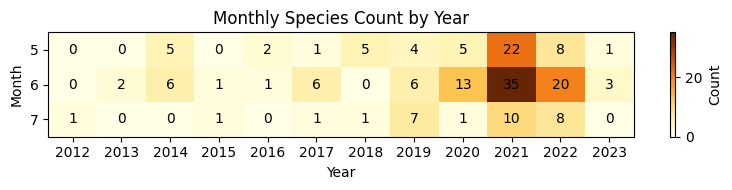

year   2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023
month                                                                        
5         0     0     5     0     2     1     5     4     5    22     8     1
6         0     2     6     1     1     6     0     6    13    35    20     3
7         1     0     0     1     0     1     1     7     1    10     8     0


In [12]:
plot_heatmap(filtered_gdf)

In [13]:
# GeoDataFrame을 Earth Engine 객체로 변환
data_raw = geemap.geopandas_to_ee(filtered_gdf)

In [ ]:
# GeoDataFrame을 Shapefile로 저장
output_shapefile = 'pitta_nympha_data.shp'
filtered_gdf.to_file(output_shapefile)

# Shapefile을 GEE 객체로 변환
data_raw = geemap.shp_to_ee(output_shapefile)

No module named 'pycrs'


In [14]:
# 공간 해상도 설정(m)
GrainSize = 1000

In [15]:
def remove_duplicates(data, GrainSize):
    # 선택한 공간 해상도(1km)에서 픽셀 당 출현 기록 하나만 무작위 선택
    random_raster = ee.Image.random().reproject('EPSG:4326', None, GrainSize)
    rand_point_vals = random_raster.sampleRegions(collection=ee.FeatureCollection(data), scale=10, geometries=True)
    return rand_point_vals.distinct('random')

In [16]:
Data = remove_duplicates(data_raw, GrainSize)

# 선택 전, 선택 후
print('Original data size:', data_raw.size().getInfo())
print('Final data size:', Data.size().getInfo())

Original data size: 176
Final data size: 111


In [19]:
# 지리적 샘플링 편향의 전처리 전(파란색)과 후(빨간색) 가시화
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

Vworld_Base = TileLayer(
    url='https://xdworld.vworld.kr/2d/Base/service/{z}/{x}/{y}.png',
    name='Vworld Base',
    attribution='Vworld',
    shown=True
)
Map.add_layer(Vworld_Base)

Map.addLayer(data_raw, {'color': 'blue'}, 'Original data')
Map.addLayer(Data, {'color': 'red'}, 'Final data')
Map.centerObject(Data.geometry(), 6)
Map

Map(center=[35.533064630393035, 126.8858638222748], controls=(WidgetControl(options=['position', 'transparent_…

### 6.2.2. 관심 영역 정의

In [20]:
# AOI 정의
AOI = Data.geometry().bounds().buffer(
    distance=50000, maxError=1000)

# 연구지역 경계를 지도에 추가
outline = ee.Image().byte().paint(
    featureCollection=AOI, color=1, width=3)

Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(AOI, 6)
Map

Map(bottom=6660.0, center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position'…

### 6.2.3. GEE 환경 변수 추가

In [21]:
# WorldClim V1 Bioclim
BIO = ee.Image("WORLDCLIM/V1/BIO")

In [22]:
# NASA SRTM Digital Elevation 30m
Terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

In [23]:
# Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m
TCC = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3")
MedianTCC = TCC.filterDate('2000-01-01', '2015-12-31')
MedianTCC = MedianTCC.select(['tree_canopy_cover'], ['TCC']).median()

In [24]:
# 밴드들을 하나의 다중 밴드 이미지로 결합
predictors = BIO.addBands(Terrain).addBands(MedianTCC)

# 수역 마스크 생성
watermask =  Terrain.select('elevation').gt(0)

# 해양 픽셀 마스킹 및 관심 영역 클리핑
predictors = predictors.updateMask(watermask).clip(AOI)

In [25]:
# 임의로 5,000개 지점 생성
DataCor = predictors.sample(
    scale=GrainSize, numPixels=5000, geometries=True)
# 예측변수 값 추출
PixelVals = predictors.sampleRegions(
    collection=DataCor, scale=GrainSize, tileScale=16)

In [26]:
# 예측변수 값 ee를 df로 변환
PixelVals_df = geemap.ee_to_df(PixelVals)
PixelVals_df.head(1)

,TCC,aspect,bio01,bio02,bio03,bio04,bio05,bio06,bio07,bio08,...,bio13,bio14,bio15,bio16,bio17,bio18,bio19,elevation,hillshade,slope
0,9.0,288,140,89,26,8572,304,-26,330,246,...,215,32,63,561,111,539,111,28,187,2


In [27]:
columns = PixelVals_df.columns
print(columns)

Index(['TCC', 'aspect', 'bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06',
       'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14',
       'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'elevation', 'hillshade',
       'slope'],
      dtype='object')


In [28]:
def plot_correlation_heatmap(dataframe, h_size=10):
    # 스피어만 상관계수 계산
    correlation_matrix = dataframe.corr(method="spearman")

    # 히트맵 그리기
    plt.figure(figsize=(h_size, h_size-2))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

    # 히트맵에 수치 표시
    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                     ha='center', va='center', color='white', fontsize=8)

    columns = dataframe.columns.tolist()
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.title("Variables correlation matrix")
    plt.colorbar(label="Spearman Correlation")
    plt.savefig('correlation_heatmap_plot.png')
    plt.show()

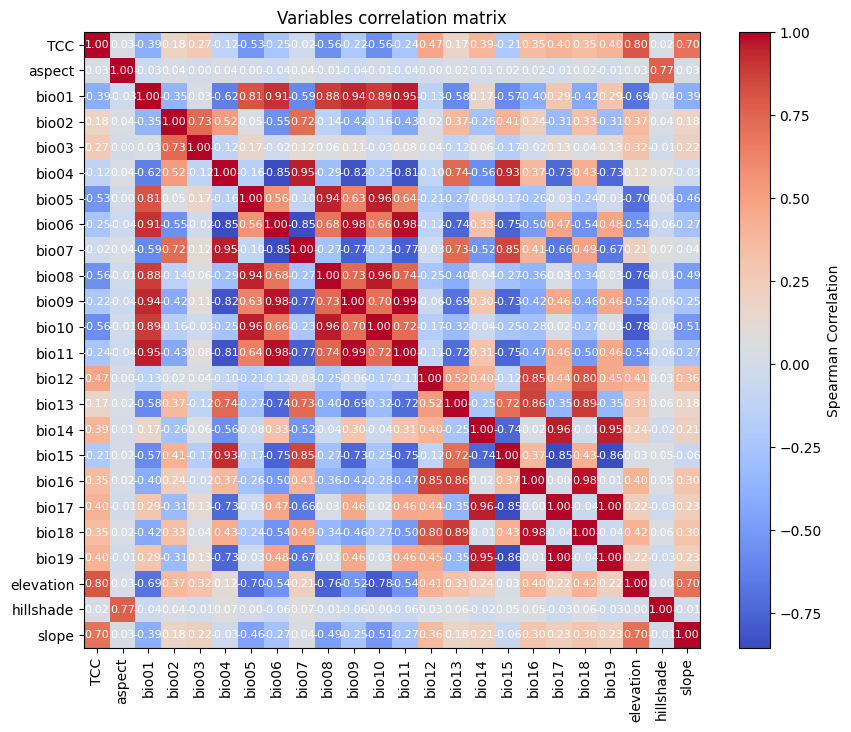

In [29]:
# 변수 상관행렬 히트맵
plot_correlation_heatmap(PixelVals_df)

In [30]:
def filter_variables_by_vif(dataframe, threshold=10):

    original_columns = dataframe.columns.tolist()
    remaining_columns = original_columns[:]

    while True:
        vif_data = dataframe[remaining_columns]
        vif_values = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

        max_vif_index = vif_values.index(max(vif_values))
        max_vif = max(vif_values)

        if max_vif < threshold:
            break

        print(f"Removing '{remaining_columns[max_vif_index]}' with VIF {max_vif:.2f}")

        del remaining_columns[max_vif_index]

    filtered_data = dataframe[remaining_columns]
    bands = filtered_data.columns.tolist()
    print('Bands:', bands)

    return filtered_data, bands

In [31]:
filtered_PixelVals_df, bands = filter_variables_by_vif(PixelVals_df)

Removing 'bio05' with VIF inf
Removing 'bio04' with VIF 183887.51
Removing 'bio10' with VIF 65297.53
Removing 'bio07' with VIF 47251.69
Removing 'bio17' with VIF 26250.72
Removing 'bio01' with VIF 9420.52
Removing 'bio16' with VIF 3705.12
Removing 'bio03' with VIF 2468.70
Removing 'bio18' with VIF 1717.42
Removing 'bio08' with VIF 1247.55
Removing 'bio06' with VIF 962.32
Removing 'bio12' with VIF 606.45
Removing 'bio19' with VIF 400.53
Removing 'bio15' with VIF 349.17
Removing 'hillshade' with VIF 130.23
Removing 'bio13' with VIF 47.32
Removing 'bio11' with VIF 31.46
Removing 'bio02' with VIF 13.75
Bands: ['TCC', 'aspect', 'bio09', 'bio14', 'elevation', 'slope']


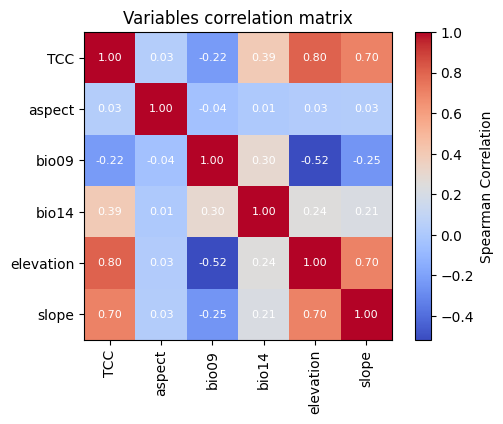

In [32]:
predictors = predictors.select(bands)
plot_correlation_heatmap(filtered_PixelVals_df, h_size=6)

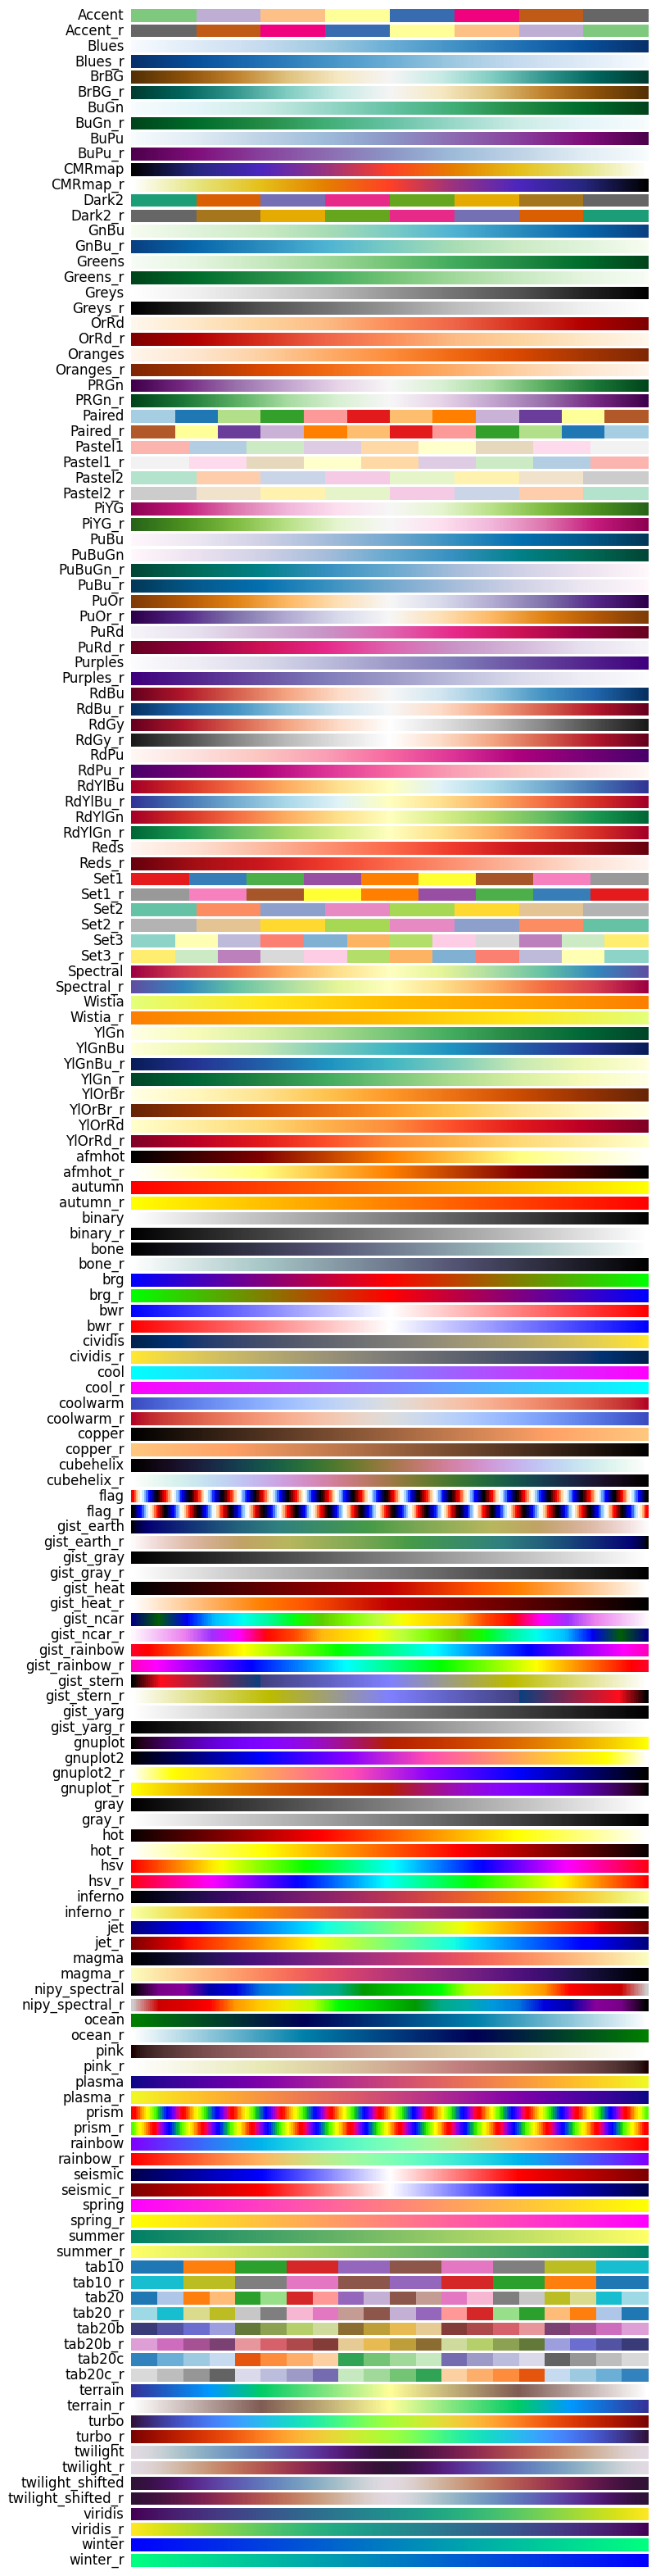

In [ ]:
cm.plot_colormaps(width=8.0, height=0.2)

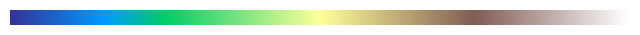

In [33]:
cm.plot_colormap('terrain',
                 width=8.0, height=0.2, orientation='horizontal')

In [34]:
# Elevation
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'bands':['elevation'],
              'min': 0, 'max': 1800, 'palette': cm.palettes.terrain}
Map.addLayer(predictors, vis_params, 'elevation')
Map.add_colorbar(vis_params, label="Elevation (m)",
                 orientation="vertical", layer_name="elevation")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

In [35]:
# bio09 최소값 & 최대값
min_val = predictors.select("bio09").multiply(0.1). \
reduceRegion(reducer=ee.Reducer.min(), scale=1000).getInfo()
max_val = predictors.select("bio09").multiply(0.1). \
reduceRegion(reducer=ee.Reducer.max(), scale=1000).getInfo()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'min': math.floor(min_val['bio09']), \
              'max': math.ceil(max_val['bio09']),
              'palette': cm.palettes.hot}
Map.addLayer(predictors.select("bio09").multiply(0.1),
             vis_params, 'bio09')
Map.add_colorbar(vis_params,
                 label="Mean temperature of driest quarter (℃)",
                 orientation="vertical", layer_name="bio09")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

In [36]:
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'bands':['slope'], 'min': 0, 'max': 25, 'palette': cm.palettes.RdYlGn_r}
Map.addLayer(predictors, vis_params, 'slope')
Map.add_colorbar(vis_params, label="Slope", orientation="vertical", layer_name="slope")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

In [37]:
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'bands':['aspect'], 'min': 0, 'max': 360, 'palette': cm.palettes.rainbow}
Map.addLayer(predictors, vis_params, 'aspect')
Map.add_colorbar(vis_params, label="Aspect", orientation="vertical", layer_name="aspect")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

In [38]:
min_val = predictors.select("bio14").reduceRegion(reducer=ee.Reducer.min(), scale=1000).getInfo()
max_val = predictors.select("bio14").reduceRegion(reducer=ee.Reducer.max(), scale=1000).getInfo()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)
vis_params = {'bands':['bio14'], 'min': math.floor(min_val['bio14']), 'max': math.ceil(max_val['bio14']), 'palette': cm.palettes.Blues}
Map.addLayer(predictors, vis_params, 'bio14')
Map.add_colorbar(vis_params, label="Precipitation of driest month (mm)", orientation="vertical", layer_name="bio14")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

In [39]:
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {'bands':['TCC'], 'min': 0, 'max': 100,
              'palette':
               ['ffffff', 'afce56', '5f9c00', '0e6a00', '003800']}
Map.addLayer(predictors, vis_params, 'TCC')
Map.add_colorbar(vis_params, label="Tree Canopy Cover (%)",
                 orientation="vertical", layer_name="TCC")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

### 6.2.4. 임의-비출현 데이터 생성

In [40]:
# 100개의 출현 위치 무작위로 선택
PixelVals = predictors.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(100),
    properties=[],
    tileScale=16,
    scale=GrainSize
)

In [41]:
# k-means 클러스터링
clusterer = ee.Clusterer.wekaKMeans(
    nClusters=2,
    distanceFunction="Euclidean"
).train(PixelVals)

Clresult = predictors.cluster(clusterer)

# 출현 위치와 유사한 클러스터 ID
clustID = Clresult.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(200),
    properties=[],
    tileScale=16,
    scale=GrainSize
)
# 유사하지 않은 클러스터에서 임의-비출현 영역 정의
clustID = ee.FeatureCollection(clustID). \
reduceColumns(ee.Reducer.mode(),['cluster'])
clustID = ee.Number(clustID.get('mode')).subtract(1).abs()
cl_mask = Clresult.select(['cluster']).eq(clustID)

In [42]:
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None,
            ee.Number(GrainSize)).mask().neq(1).selfMask()

In [43]:
AreaForPA = presence_mask.updateMask(cl_mask).clip(AOI)

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

### 6.2.5. 모델 적합 및 예측

In [44]:
# 공간 블록 교차 검증을 위한 격자 생성
def makeGrid(geometry, scale):
    # 경도 & 위도 도 단위 이미지 생성
    lonLat = ee.Image.pixelLonLat()
    # 경도 & 위도 이미지 정수화
    lonGrid = lonLat.select('longitude').multiply(100000).toInt()
    latGrid = lonLat.select('latitude').multiply(100000).toInt()

    return lonGrid.multiply(latGrid).reduceToVectors(
        # geometry 경계 포함 격자 생성
        geometry = geometry.buffer(distance=20000, maxError=1000),
        scale = scale,
        geometryType = 'polygon'
    )

In [45]:
Scale = 50000
grid = makeGrid(AOI, Scale)
Grid = watermask.reduceRegions(
    collection=grid,
    reducer=ee.Reducer.mean()).filter(ee.Filter.neq('mean', None))

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)
Map.addLayer(Grid, {}, "Grid for spatial block cross validation")
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

In [46]:
def SDM(x):
    Seed = ee.Number(x)

    # 훈련 및 검증을 위한 무작위 블록 분할
    GRID = ee.FeatureCollection(Grid).randomColumn(seed=Seed).sort('random')
    TrainingGrid = GRID.filter(ee.Filter.lt('random', split)) # 훈련용 격자
    TestingGrid = GRID.filter(ee.Filter.gte('random', split)) # 시험용 격자

    # 출현 지점
    PresencePoints = ee.FeatureCollection(Data)
    PresencePoints = PresencePoints.map(lambda feature: feature.set('PresAbs', 1))
    TrPresencePoints = PresencePoints.filter(ee.Filter.bounds(TrainingGrid)) # 훈련용 출현 지점
    TePresencePoints = PresencePoints.filter(ee.Filter.bounds(TestingGrid)) # 시험용 출현 지점

    # 임의-비출현 지점
    TrPseudoAbsPoints = AreaForPA.sample(region=TrainingGrid,
                                         scale=GrainSize,
                                         numPixels=TrPresencePoints.size().add(300),
                                         seed=Seed,
                                         geometries=True)
    # 훈련용 출현 지점과 동일한 수의 임의-비출현 지점
    TrPseudoAbsPoints = TrPseudoAbsPoints.randomColumn().sort('random').limit(ee.Number(TrPresencePoints.size()))
    TrPseudoAbsPoints = TrPseudoAbsPoints.map(lambda feature: feature.set('PresAbs', 0))

    TePseudoAbsPoints = AreaForPA.sample(region=TestingGrid,
                                         scale=GrainSize,
                                         numPixels=TePresencePoints.size().add(100),
                                         seed=Seed,
                                         geometries=True)
    # 검증용 출현 지점과 동일한 수의 임의-비출현 지점
    TePseudoAbsPoints = TePseudoAbsPoints.randomColumn().sort('random').limit(ee.Number(TePresencePoints.size()))
    TePseudoAbsPoints = TePseudoAbsPoints.map(lambda feature: feature.set('PresAbs', 0))

    # 훈련 및 임의-비출현 지점 병합
    trainingPartition = TrPresencePoints.merge(TrPseudoAbsPoints)
    testingPartition = TePresencePoints.merge(TePseudoAbsPoints)

    # 훈련용 지점에서 예측 변수 이미지의 공변량 값 추출
    trainPixelVals = predictors.sampleRegions(collection=trainingPartition,
                                              properties=['PresAbs'],
                                              scale=GrainSize,
                                              tileScale=16,
                                              geometries=True)

    # 랜덤 포레스트 분류기(Random Forest classifier)
    Classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=500, # 생성할 결정 트리의 수
        variablesPerSplit=None, # 분할당 변수의 수. 기본값: 변수 수의 제곱근 사용
        minLeafPopulation=10, # 훈련 셋에 최소한 이 개수의 지점이 포함된 노드만 생성
        bagFraction=0.5, # 트리당 백에 대한 입력 비율
        maxNodes=None, # 각 트리의 최대 리프 노드 수. 기본값: 제한 없음
        seed=Seed # 무작위화 시드
    )
    # 출현 확률(Presence probability)
    ClassifierPr = Classifier.setOutputMode('PROBABILITY').train(trainPixelVals, 'PresAbs', bands)
    ClassifiedImgPr = predictors.select(bands).classify(ClassifierPr)

    # 이진 출현/비출현 지도(Binary presence/absence map)
    ClassifierBin = Classifier.setOutputMode('CLASSIFICATION').train(trainPixelVals, 'PresAbs', bands)
    ClassifiedImgBin = predictors.select(bands).classify(ClassifierBin)

    return [ClassifiedImgPr, ClassifiedImgBin, trainingPartition, testingPartition], ClassifierPr

In [47]:
split = 0.7
numiter = 10
runif = lambda length: [random.randint(1, 1000) \
                        for _ in range(length)] # 시드
items = runif(numiter)
# items = [287, 288, 553, 226, 151, 255, 902, 267, 419, 538]

In [48]:
results_list = [] # SDM 결과 리스트 초기화
importances_list = [] # 변수 중요도 리스트 초기화

for item in runif(numiter):
    result, trained = SDM(item)
    # SDM 결과 리스트 누적
    results_list.extend(result)

    # 변수 중요도 리스트 누적
    importance = ee.Dictionary(trained.explain()).get('importance')
    importances_list.extend(importance.getInfo().items())

# SDM 결과 누적
results = ee.List(results_list).flatten()

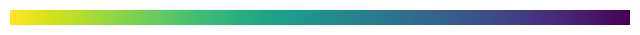

In [54]:
cm.plot_colormap('viridis_r',
                 width=8.0, height=0.2, orientation='horizontal')

In [52]:
# 서식지 적합성 지도(Habitat suitability map)
images = ee.List.sequence(
    0, ee.Number(numiter).multiply(4).subtract(1), 4).\
    map(lambda x: results.get(x))
ModelAverage = ee.ImageCollection.fromImages(images).mean()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {
    'min': 0,
    'max': 1,
    'palette': cm.palettes.viridis_r}
Map.addLayer(ModelAverage, vis_params, 'Habitat suitability')
Map.add_colorbar(vis_params, label="Habitat suitability",
                 orientation="horizontal",
                 layer_name="Habitat suitability")
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.centerObject(AOI, 6)
Map

Map(center=[35.587733558095216, 126.8959721004684], controls=(WidgetControl(options=['position', 'transparent_…

In [53]:
# 잠재 분포 지도(Potential distribution map)
images2 = ee.List.sequence(1, ee.Number(numiter).multiply(4).\
                           subtract(1), 4).map(lambda x: results.get(x))
DistributionMap = ee.ImageCollection.fromImages(images2).mode()

Map = geemap.Map(layout={'height':'400px', 'width':'800px'})
Map.add_layer(Vworld_Base)

vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map.addLayer(DistributionMap, vis_params, 'Potential distribution')
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.add_colorbar(vis_params, label="Potential distribution",
                 discrete=True, orientation="horizontal",
                 layer_name="Potential distribution")
Map.centerObject(Data.geometry(), 6)
Map

Map(center=[35.533064630393035, 126.8858638222748], controls=(WidgetControl(options=['position', 'transparent_…

### 6.2.6. 변수 중요도 및 정확도 평가

In [55]:
# 각 변수 중요도 값을 리스트로 추출
variables = [item[0] for item in importances_list]
importances = [item[1] for item in importances_list]

# 변수 중요도 평균 계산
average_importances = {}
for variable in set(variables):
    indices = [i for i, var in enumerate(variables) if var == variable]
    average_importance = np.mean([importances[i] for i in indices])
    average_importances[variable] = average_importance

# 평균 변수 중요도 출력
for variable, avg_importance in average_importances.items():
    print(f"{variable}: {avg_importance}")

TCC: 24.92725667109963
aspect: 4.294282724803127
elevation: 51.68618109723307
bio09: 23.48159181747482
bio14: 13.650367079857716
slope: 9.224369564298456


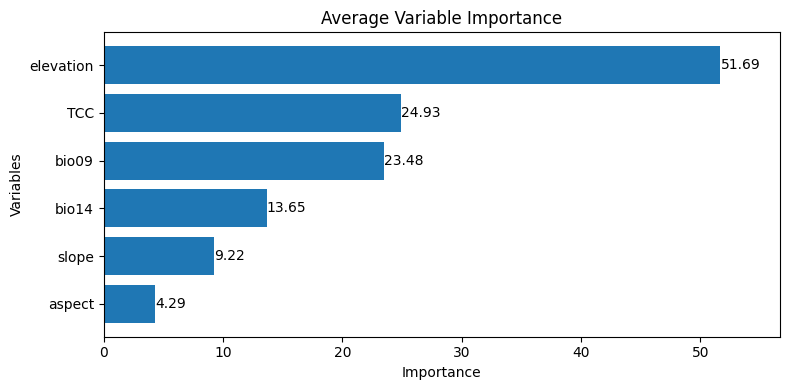

In [56]:
# 변수 중요도가 높은 순으로 정렬
sorted_importances = sorted(average_importances.items(),
                            key=lambda x: x[1], reverse=False)
variables = [item[0] for item in sorted_importances]
avg_importances = [item[1] for item in sorted_importances]

# 그래프 크기 조절
plt.figure(figsize=(8, 4))  # 원하는 크기로 조절

# 막대그래프로 평균 중요도 출력
plt.barh(variables, avg_importances)
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.title('Average Variable Importance')

# 막대 위에 수치 표시
for i, v in enumerate(avg_importances):
    plt.text(v + 0.02, i, f"{v:.2f}", va='center')

# x축 범위 조정
plt.xlim(0, max(avg_importances) + 5)  # 원하는 범위로 조절

plt.tight_layout()
plt.savefig('variable_importance.png')
plt.show()

In [57]:
def print_pres_abs_sizes(TestingDatasets, numiter):
    # 출현 및 임의-비출현 좌표가 충분한 지 체크 및 출력
    def get_pres_abs_size(x):
        fc = ee.FeatureCollection(TestingDatasets.get(x))
        presence_size = fc.filter(ee.Filter.eq('PresAbs', 1)).size()
        pseudo_absence_size = fc.filter(ee.Filter.eq('PresAbs', 0)).size()
        return ee.List([presence_size, pseudo_absence_size])

    sizes_info = ee.List.sequence(0, ee.Number(numiter).subtract(1), 1).map(get_pres_abs_size).getInfo()

    for i, sizes in enumerate(sizes_info):
        presence_size = sizes[0]
        pseudo_absence_size = sizes[1]
        print(f'Iteration {i + 1}: Presence Size = {presence_size}, Pseudo-absence Size = {pseudo_absence_size}')

In [58]:
# 검증용 데이터셋 추출
TestingDatasets = (ee.List.sequence(3, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x)))

print_pres_abs_sizes(TestingDatasets, numiter)

Iteration 1: Presence Size = 52, Pseudo-absence Size = 34
Iteration 2: Presence Size = 36, Pseudo-absence Size = 24
Iteration 3: Presence Size = 51, Pseudo-absence Size = 41
Iteration 4: Presence Size = 49, Pseudo-absence Size = 36
Iteration 5: Presence Size = 29, Pseudo-absence Size = 29
Iteration 6: Presence Size = 34, Pseudo-absence Size = 26
Iteration 7: Presence Size = 26, Pseudo-absence Size = 26
Iteration 8: Presence Size = 24, Pseudo-absence Size = 23
Iteration 9: Presence Size = 28, Pseudo-absence Size = 28
Iteration 10: Presence Size = 14, Pseudo-absence Size = 14


In [59]:
def getAcc(HSM, TData, GrainSize):
    Pr_Prob_Vals = HSM.sampleRegions(collection=TData, properties=['PresAbs'], scale=GrainSize, tileScale=16)
    seq = ee.List.sequence(start=0, end=1, count=25) # Divide 0 to 1 into 25 intervals
    def calculate_metrics(cutoff):
        # Each element of the seq list is passed as cutoff(threshold value)

        # Observed present = TP + FN
        Pres = Pr_Prob_Vals.filterMetadata('PresAbs', 'equals', 1)

        # TP (True Positive)
        TP = ee.Number(Pres.filterMetadata('classification', 'greater_than', cutoff).size())

        # TPR (True Positive Rate) = Recall = Sensitivity = TP / (TP + FN) = TP / Observed present
        TPR = TP.divide(Pres.size())

        # Observed absent = FP + TN
        Abs = Pr_Prob_Vals.filterMetadata('PresAbs', 'equals', 0)

        # FN (False Negative)
        FN = ee.Number(Pres.filterMetadata('classification', 'less_than', cutoff).size())

        # TNR (True Negative Rate) = Specificity = TN  / (FP + TN) = TN / Observed absent
        TN = ee.Number(Abs.filterMetadata('classification', 'less_than', cutoff).size())
        TNR = TN.divide(Abs.size())

        # FP (False Positive)
        FP = ee.Number(Abs.filterMetadata('classification', 'greater_than', cutoff).size())

        # FPR (False Positive Rate) = FP / (FP + TN) = FP / Observed absent
        FPR = FP.divide(Abs.size())

        # Precision = TP / (TP + FP) = TP / Predicted present
        Precision = TP.divide(TP.add(FP))

        # SUMSS = SUM of Sensitivity and Specificity
        SUMSS = TPR.add(TNR)

        return ee.Feature(
            None,
            {
                'cutoff': cutoff,
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'TPR': TPR,
                'TNR': TNR,
                'FPR': FPR,
                'Precision': Precision,
                'SUMSS': SUMSS
            }
        )

    return ee.FeatureCollection(seq.map(calculate_metrics))

In [60]:
def calculate_and_print_auc_metrics(images, TestingDatasets, GrainSize, numiter):
    # AUC-ROC와 AUC-PR 계산
    def calculate_auc_metrics(x):
        HSM = ee.Image(images.get(x))
        TData = ee.FeatureCollection(TestingDatasets.get(x))
        Acc = getAcc(HSM, TData, GrainSize)

        # AUC-ROC 계산
        X = ee.Array(Acc.aggregate_array('FPR'))
        Y = ee.Array(Acc.aggregate_array('TPR'))
        X1 = X.slice(0,1).subtract(X.slice(0,0,-1))
        Y1 = Y.slice(0,1).add(Y.slice(0,0,-1))
        auc_roc = X1.multiply(Y1).multiply(0.5).reduce('sum',[0]).abs().toList().get(0)

        # AUC-PR 계산
        X = ee.Array(Acc.aggregate_array('TPR'))
        Y = ee.Array(Acc.aggregate_array('Precision'))
        X1 = X.slice(0,1).subtract(X.slice(0,0,-1))
        Y1 = Y.slice(0,1).add(Y.slice(0,0,-1))
        auc_pr = X1.multiply(Y1).multiply(0.5).reduce('sum',[0]).abs().toList().get(0)

        return (auc_roc, auc_pr)

    auc_metrics = ee.List.sequence(0, ee.Number(numiter).subtract(1), 1).map(calculate_auc_metrics).getInfo()

    # 각 반복마다 AUC-ROC와 AUC-PR 출력
    df = pd.DataFrame(auc_metrics, columns=['AUC-ROC', 'AUC-PR'])
    df.index = [f'Iteration {i + 1}' for i in range(len(df))]
    df.to_csv('auc_metrics.csv', index_label='Iteration')
    print(df)

    # AUC-ROC와 AUC-PR의 평균과 표준편차 계산
    mean_auc_roc, std_auc_roc = df['AUC-ROC'].mean(), df['AUC-ROC'].std()
    mean_auc_pr, std_auc_pr = df['AUC-PR'].mean(), df['AUC-PR'].std()
    print(f'Mean AUC-ROC = {mean_auc_roc:.4f} ± {std_auc_roc:.4f}')
    print(f'Mean AUC-PR = {mean_auc_pr:.4f} ± {std_auc_pr:.4f}')

In [61]:
%%time

# AUC-ROC와 AUC-PR 계산
calculate_and_print_auc_metrics(images, TestingDatasets, GrainSize, numiter)

               AUC-ROC    AUC-PR
Iteration 1   0.823529  0.798220
Iteration 2   0.881048  0.739325
Iteration 3   0.838415  0.795769
Iteration 4   0.867886  0.785650
Iteration 5   0.776457  0.652921
Iteration 6   0.960852  0.911284
Iteration 7   0.915865  0.885071
Iteration 8   0.696597  0.694279
Iteration 9   0.753307  0.784270
Iteration 10  0.885714  0.722837
Mean AUC-ROC = 0.8400 ± 0.0798
Mean AUC-PR = 0.7770 ± 0.0797
CPU times: user 1.47 s, sys: 105 ms, total: 1.57 s
Wall time: 2min 25s


In [62]:
def calculate_and_print_ss_metrics(images, TestingDatasets, GrainSize, numiter):
    # 민감도(Sensitivity)와 특이도(Specificity) 계산
    def calculate_ss_metrics(x):
        HSM = ee.Image(images.get(x))
        TData = ee.FeatureCollection(TestingDatasets.get(x))
        Acc = getAcc(HSM, TData, GrainSize)

        # 민감도(Sensitivity) 계산
        sensitivity = Acc.sort('SUMSS', False).first().get('TPR')

        # 특이도(Specificity) 계산
        specificity = Acc.sort('SUMSS', False).first().get('TNR')

        return (sensitivity, specificity)

    ss_metrics = ee.List.sequence(0, ee.Number(numiter).subtract(1), 1).map(calculate_ss_metrics).getInfo()

    # 각 반복마다 민감도와 특이도 출력
    df = pd.DataFrame(ss_metrics, columns=['Sensitivity', 'Specificity'])
    df.index = [f'Iteration {i + 1}' for i in range(len(df))]
    df.to_csv('ss_metrics.csv', index_label='Iteration')
    print(df)

    # 민감도와 특이도의 평균과 표준편차 계산
    mean_sensitivity, std_sensitivity = df['Sensitivity'].mean(), df['Sensitivity'].std()
    mean_specificity, std_specificity = df['Specificity'].mean(), df['Specificity'].std()
    print(f'Mean Sensitivity = {mean_sensitivity:.4f} ± {std_sensitivity:.4f}')
    print(f'Mean Specificity = {mean_specificity:.4f} ± {std_specificity:.4f}')

In [63]:
%%time

# 민감도(sensitivity)와 특이도(specificity) 계산
# 민감도(sensitivity): 출현 예측의 정확성
# 특이도(specificity): 비출현 예측의 정확성
calculate_and_print_ss_metrics(images, TestingDatasets, GrainSize, numiter)

              Sensitivity  Specificity
Iteration 1      0.688889     0.823529
Iteration 2      0.838710     0.750000
Iteration 3      0.772727     0.780488
Iteration 4      0.926829     0.722222
Iteration 5      0.517241     0.896552
Iteration 6      0.964286     0.846154
Iteration 7      0.958333     0.884615
Iteration 8      0.434783     1.000000
Iteration 9      0.703704     0.750000
Iteration 10     1.000000     0.571429
Mean Sensitivity = 0.7806 ± 0.1948
Mean Specificity = 0.8025 ± 0.1168
CPU times: user 1.11 s, sys: 103 ms, total: 1.21 s
Wall time: 2min 14s


In [66]:
def plot_roc_pr_curves(images, TestingDatasets, GrainSize, numiter):
    # Plot ROC and PR curves
    def get_roc_pr_values(x):
        HSM = ee.Image(images.get(x))
        TData = ee.FeatureCollection(TestingDatasets.get(x))
        Acc = getAcc(HSM, TData, GrainSize)

        # Get ROC and PR values
        varFPR = Acc.aggregate_array('FPR')
        varTPR = Acc.aggregate_array('TPR')
        varPrecision = Acc.aggregate_array('Precision')

        return (varFPR, varTPR, varPrecision)

    # Retrieve ROC and PR values for each iteration and model
    roc_pr_values = np.array(ee.List.sequence(0, ee.Number(numiter).subtract(1), 1).map(get_roc_pr_values).getInfo())

    all_model_data = []
    for model_data in roc_pr_values:
        # Transpose data to match the desired format
        transposed_data = np.transpose(model_data)
        all_model_data.append(transposed_data)

    # Calculate mean and standard deviation across models
    mean_data = np.mean(all_model_data, axis=0)
    std_data = np.std(all_model_data, axis=0)

    # Create DataFrames for mean and standard deviation data
    df_mean = pd.DataFrame(mean_data, columns=['FPR', 'TPR', 'Precision'])
    df_std = pd.DataFrame(std_data, columns=['FPR', 'TPR', 'Precision'])

    # Set font size and style
    plt.rcParams.update({'font.size': 14})

    # Create a figure with two subplots
    plt.figure(figsize=(16, 6))

    # Plot mean ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(df_mean['FPR'], df_mean['TPR'], color='blue', lw=2, label='Mean ROC Curve')
    plt.fill_between(df_mean['FPR'], df_mean['TPR'] - df_std['TPR'], df_mean['TPR'] + df_std['TPR'], color='gray', alpha=0.2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) curve')
    plt.grid(True)
    plt.legend(loc='lower right')

    # Plot mean PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(df_mean['TPR'], df_mean['Precision'], color='blue', lw=2, label='Mean PR Curve')
    plt.fill_between(df_mean['TPR'], df_mean['Precision'] - df_std['Precision'], df_mean['Precision'] + df_std['Precision'], color='gray', alpha=0.2)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (PR) curve')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('roc_pr_curves_plot.png')
    plt.show()

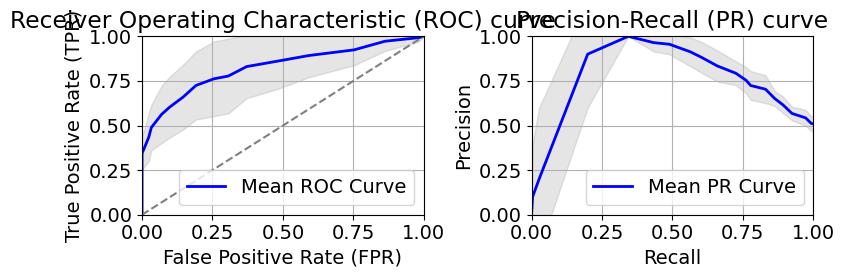

CPU times: user 2.26 s, sys: 318 ms, total: 2.57 s
Wall time: 3min 39s


In [67]:
%%time

# ROC and PR 곡선 플롯
plot_roc_pr_curves(images, TestingDatasets, GrainSize, numiter)

In [ ]:
%%time

# Extract the optimal threshold
MeanThresh = ee.Number(ee.FeatureCollection(Metrics).aggregate_array("cutoff").reduce(ee.Reducer.mean()))
print('Mean threshold:', MeanThresh.getInfo())

In [ ]:
# Custom Binary Distribution Mapping Based on Optimal Threshold
DistributionMap2 = ModelAverage.gte(MeanThresh)
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map = geemap.Map()
Map.addLayer(DistributionMap2, vis_params, 'Potential distribution2')
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.add_colorbar(vis_params, label="Potential distribution2", discrete=True, orientation="horizontal", layer_name="Potential distribution2")
Map.centerObject(Data.geometry(), 7)
Map

### 10. Export Results

In [ ]:
out_dir = 'D:/GEODATA'

# Save the Habitat Suitability Map as a GeoTIFF
out_file = os.path.join(out_dir, 'habitat_suitability.tif')
geemap.ee_export_image(ModelAverage, filename=out_file, region=AOI, scale=1000, maxPixels=1e13)

# Save the Potential Distribution Map as a GeoTIFF
out_file = os.path.join(out_dir, 'distribution_map.tif')
geemap.ee_export_image(DistributionMap, filename=out_file, region=AOI, scale=1000, maxPixels=1e13)

# Save the Potential Distribution Map using the optimal threshold as a GeoTIFF
out_file = os.path.join(out_dir, 'distribution_map2.tif')
geemap.ee_export_image(DistributionMap2, filename=out_file, region=AOI, scale=1000, maxPixels=1e13)